# Datatonic OpenLibrary Coding Challenge
## What makes a great book in OpenLibrary? 📚

**Specifically: *What features contribute to the reading preferences of OpenLibrary's users?*** 

**Scoping and Assumptions:**
*Query Scope*
- I will be limiting my query to works that have **at least one readinglog_count**.
- I will initially limit the **first_publish_year to 2019** to run through my operations on a limited dataset before building it out to multiple years

*Measures of popularity and preference*
- I will be using **readinglog_count** and **rating** as the outcome measures.
  - Its important to note that readinglog_count does not indicate the number of times that a book has been borrowed through OpenLibrary, but is a sum of the user-entered fields *want_to_read_count, currently_reading_count,* and *already_read_count*. This means it is not the perfect measure of popularity of a book - ideally we'd use data from the borrowing log, or page clicks. I reached out to the OpenLibrary program manager 'Mek' (Michael...) however he confirmed this data was not available to the public. So we'll have to rely on this for now.

*Features under consideration*
- The following features are being considered to determine which factors are the best predictors (and therefore make the greatest contribution) to the popularity and rating of books for OpenLibrary's users.
  - 'first_publish_year, title, author_name, language, number_of_pages_median,publisher, format, subject, ratings_average, ratings_sortable, ratings_count, readinglog_count, want_to_read_count, currently_reading_count, already_read_count, first_sentence',


In [1]:
"""
Step 1. Construct and Convert the Query with Luqum (to be readable by apache solr, the query type specified in OpenLibrary's documentation)
"""
from luqum.parser import parser
from luqum.pretty import prettify
#from luqum.tree import Word, Range

# Create a query for books first published in 2019 and with readinglog_count > 0 and with median number of pages between 1 and 4000[*]
query = parser.parse('readinglog_count:[1 TO *] AND ratings_count:[1 TO *] AND language:eng')

# Convert the query to a Solr query string
solr_query = prettify(query)
print(solr_query)

readinglog_count: [1 TO *] AND ratings_count: [1 TO *] AND language: eng


In [18]:
%%time
"""
Step 2. Make API Call
"""
import requests

# OpenLibrary API endpoint
url = 'http://openlibrary.org/search.json'

# Query parameters
params = {
    'q': solr_query,
    'sort': 'readinglog',
    'fields': 'first_publish_year,title,author_name,number_of_pages_median,publisher,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count',
    'limit': 20000  # Limit sample of results
}

try:
    response = requests.get(url, params=params)
    response.raise_for_status()  # Check for HTTP errors
    data = response.json()  # Attempt to parse JSON
    print(f"{data['numFound']} works")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")
except ValueError as e:
    print(f"JSON decoding failed: {e}")


167487 works
CPU times: user 260 ms, sys: 178 ms, total: 438 ms
Wall time: 1min 5s


In [19]:
"""
Step 3. Load dataset into Pandas DataFrame and perform initial data overview
"""

import pandas as pd

data_df = pd.DataFrame.from_records(data['docs'])
data_df.head()

,author_name,first_publish_year,number_of_pages_median,publisher,title,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count
0,[Colleen Hoover],2012.0,384.0,"[Athreya, Simon & Schuster, Epsilon Yayinevi, ...",It Ends With Us,"[Fiction, Romance, Contemporary, Life change e...",4.239496,4.163510,952,38532,35221,2128,1183
1,[James Clear],2016.0,320.0,"[Random House, Incorporated, editora alta book...",Atomic Habits,"[Habit, Habit breaking, Behavior modification,...",4.054461,3.967740,863,38352,34811,2548,993
2,"[Robert Greene, Joost Elffers]",1998.0,452.0,"[Editora Rocco, Viking, Hachette Australia, Ca...",The 48 Laws of Power,"[Business, Control (Psychology), Contrôle (Psy...",4.126276,4.036836,784,32460,29616,2096,748
3,[Mark Manson],2016.0,224.0,"[HarperLuxe, Harpercollins, Mark Manson , Inde...",The Subtle Art of Not Giving a F*ck,"[Self-realization, Conduct of life, Conducta d...",4.116279,4.015137,602,29438,27104,1727,607
4,"[Robert T. Kiyosaki, Sharon L. Lechter]",1990.0,233.0,"[Running Press, Bespoke Books, Gao Bao/ Tsai F...","Rich Dad, Poor Dad","[Rich people, Personal Finance, Investments, F...",4.083707,3.987700,669,21948,19230,1969,749


In [44]:
"""
Quality Check
"""

# Check for missing / null data
data_df.isnull().sum().sort_values(ascending=False) / len(data_df)

subject                    0.05155
number_of_pages_median     0.04035
publisher                  0.00345
author_name                0.00110
first_publish_year         0.00080
title                      0.00000
ratings_average            0.00000
ratings_sortable           0.00000
ratings_count              0.00000
readinglog_count           0.00000
want_to_read_count         0.00000
currently_reading_count    0.00000
already_read_count         0.00000
bin                        0.00000
title_author               0.00000
dtype: float64

In [41]:
# Duplicates

# Since it is possible to have the same title for different books AND for one author to have published multiple books, let's
# create a composite column of 'title by author_name'
data_df['title_author'] = data_df.apply(lambda row: f"{row['title']} by {row['author_name']}", axis=1)
print(data_df[['title', 'author_name', 'title_author']].head())

# check duplicates using this composite column 'title_author' compared to others
print(f"Duplicates: title_author: {data_df['title_author'].duplicated().sum()} vs title: {data_df['title'].duplicated().sum()} vs author: {data_df['author_name']}.")

                                 title  \
0                      It Ends With Us   
1                        Atomic Habits   
2                 The 48 Laws of Power   
3  The Subtle Art of Not Giving a F*ck   
4                   Rich Dad, Poor Dad   

                               author_name  \
0                         [Colleen Hoover]   
1                            [James Clear]   
2           [Robert Greene, Joost Elffers]   
3                            [Mark Manson]   
4  [Robert T. Kiyosaki, Sharon L. Lechter]   

                                        title_author  
0              It Ends With Us by ['Colleen Hoover']  
1                   Atomic Habits by ['James Clear']  
2  The 48 Laws of Power by ['Robert Greene', 'Joo...  
3  The Subtle Art of Not Giving a F*ck by ['Mark ...  
4  Rich Dad, Poor Dad by ['Robert T. Kiyosaki', '...  
Duplicates: title_author: 216 vs title: 764 vs author: 0                                         [Colleen Hoover]
1                         

In [55]:
#import numpy as np

# Error at index 1223 for Revel for Essentials of Organizational Behaviour, Second Canadian Edition -- Access Card'
# 'number_of_pages_median' = 99 999 is an error! Checked online and found that it is 432 pages. https://www.amazon.ca/Essentials-Organizational-Behaviour-Second-Canadian/dp/013524160X


max_index = data_df['number_of_pages_median'].idxmax()
max_row = data_df.loc[max_index]
max_row


author_name                                               [Kaplan Test Prep]
first_publish_year                                                      2019
format                                                           [paperback]
language                                                                 NaN
number_of_pages_median                                                  3288
publisher                         [Kaplan Grad Test Prep, Kaplan Publishing]
title                          MCAT Complete 7-Book Subject Review 2020-2021
subject                                                                  NaN
readinglog_count                                                           2
want_to_read_count                                                         2
currently_reading_count                                                    0
already_read_count                                                         0
ratings_average                                                          NaN

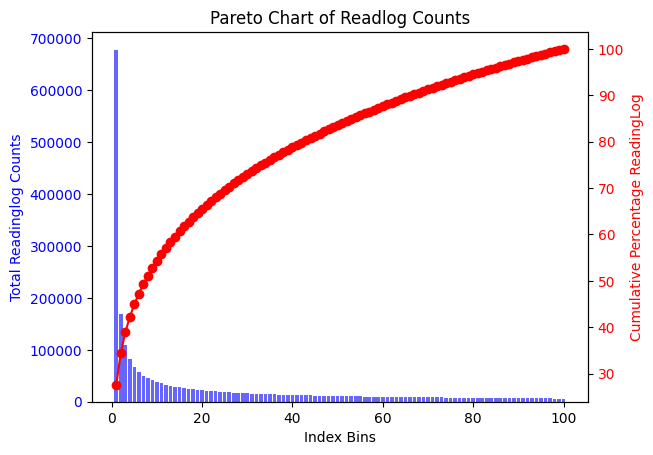

Our top 11 bins (2200 books, or 1.31% of all read and rated english works, account for 80% of all readinglog counts.


In [21]:
"""
Analysis: Pareto Chart of Ordered Books' Readinglog Counts and Cumulative Percentage of Total Counts
"""

# Define the bin size
bin_size = 200

# Create bins and group by these bins
data_df['bin'] = (data_df.index // bin_size) + 1
bin_totals = data_df.groupby('bin')['readinglog_count'].sum().reset_index()

# Calculate cumulative sum and cumulative percentage
bin_totals['cumulative_sum'] = bin_totals['readinglog_count'].cumsum()
bin_totals['cumulative_percentage'] = bin_totals['cumulative_sum'] / bin_totals['readinglog_count'].sum() * 100

fig, ax1 = plt.subplots()

# Plot total read counts on the primary y-axis
ax1.bar(bin_totals['bin'], bin_totals['readinglog_count'], color='b', alpha=0.6)
ax1.set_xlabel('Index Bins')
ax1.set_ylabel('Total Readinglog Counts', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot cumulative percentage on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(bin_totals['bin'], bin_totals['cumulative_percentage'], color='r', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Percentage ReadingLog', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Pareto Chart of Readlog Counts')
plt.show()

print(f"Our top 11 bins (2200 books, or {round((2200/167484)*100,2)}% of all read and rated english works, account for 80% of all readinglog counts.")

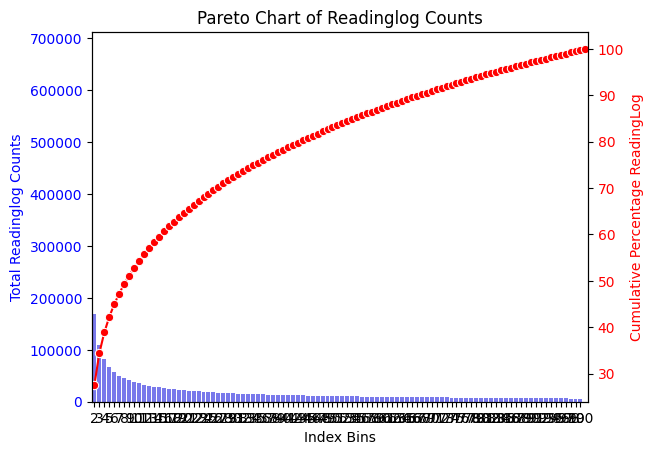

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bin size
bin_size = 200

# Create bins and group by these bins
data_df['bin'] = (data_df.index // bin_size) + 1
bin_totals = data_df.groupby('bin')['readinglog_count'].sum().reset_index()

# Calculate cumulative sum and cumulative percentage
bin_totals['cumulative_sum'] = bin_totals['readinglog_count'].cumsum()
bin_totals['cumulative_percentage'] = bin_totals['cumulative_sum'] / bin_totals['readinglog_count'].sum() * 100

# Create the plot
fig, ax1 = plt.subplots()

# Plot total readinglog counts on the primary y-axis
sns.barplot(x='bin', y='readinglog_count', data=bin_totals, ax=ax1, color='b', alpha=0.6)
ax1.set_xlabel('Index Bins')
ax1.set_ylabel('Total Readinglog Counts', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot cumulative percentage on the secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(x='bin', y='cumulative_percentage', data=bin_totals, ax=ax2, color='r', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Percentage ReadingLog', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Ensure the line plot starts at the first bin
# ax2.set_ylim(0, 100)
ax2.set_xlim(0.5, bin_totals['bin'].max() + 0.5)

plt.title('Pareto Chart of Readinglog Counts')
plt.show()

In [14]:
data_df['readinglog_count'].max()

np.int64(38532)

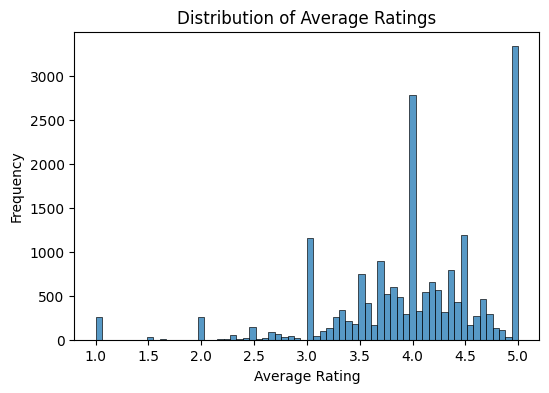

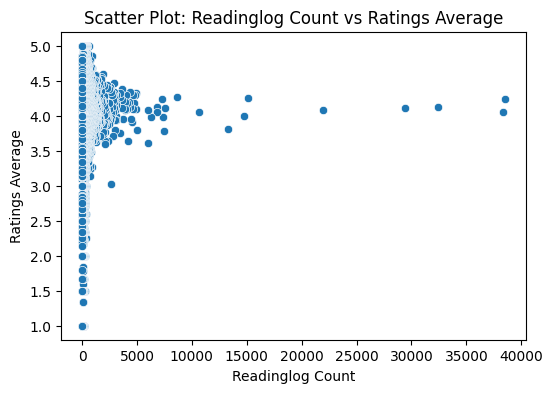

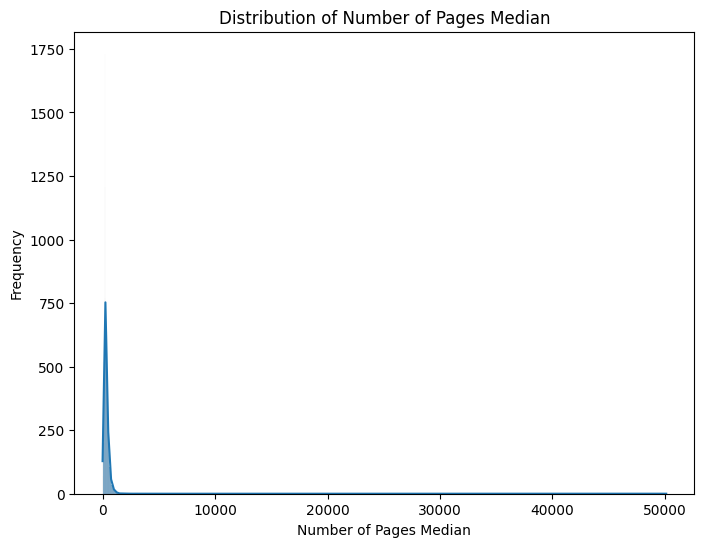

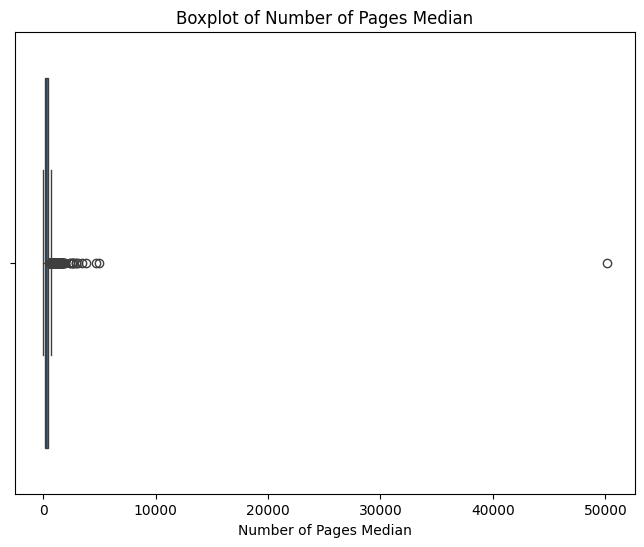

In [38]:
# Histogram with KDE
plt.figure(figsize=(6, 4))
sns.histplot(data_df['ratings_average'])
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of readinglog_count vs. ratings_average
plt.figure(figsize=(6, 4))
sns.scatterplot(x='readinglog_count', y='ratings_average', data=data_df)
plt.title('Scatter Plot: Readinglog Count vs Ratings Average')
plt.xlabel('Readinglog Count')
plt.ylabel('Ratings Average')
plt.show()

# Histogram with KDE
plt.figure(figsize=(8, 6))
sns.histplot(data_df['number_of_pages_median'], kde=True)
plt.title('Distribution of Number of Pages Median')
plt.xlabel('Number of Pages Median')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_df, x='number_of_pages_median')
plt.title('Boxplot of Number of Pages Median')
plt.xlabel('Number of Pages Median')
plt.show()

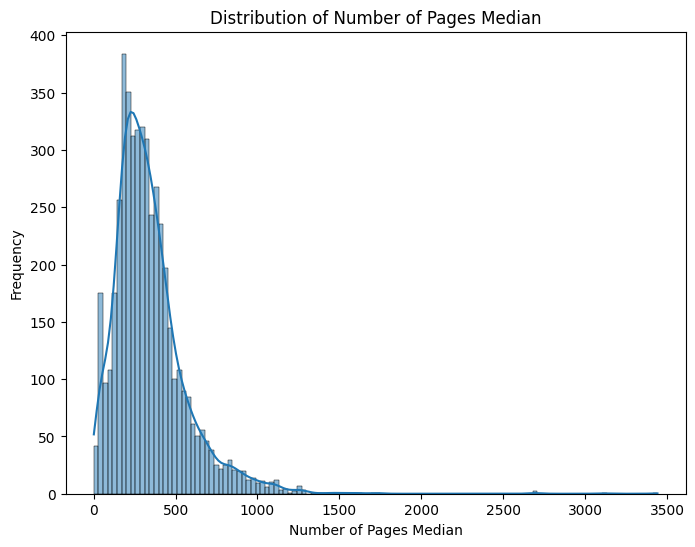

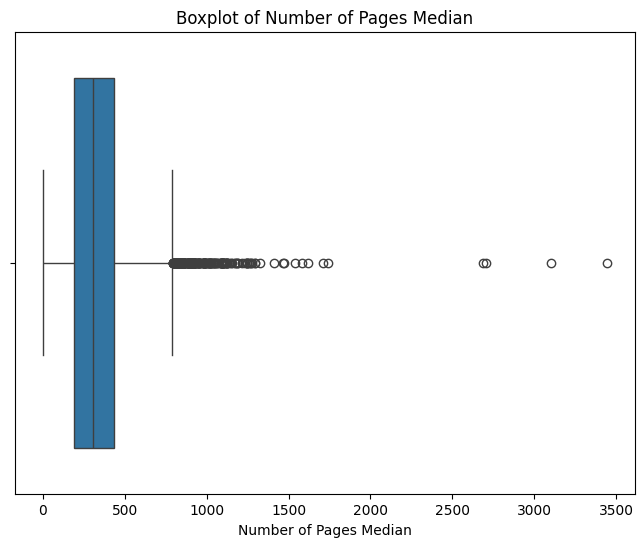

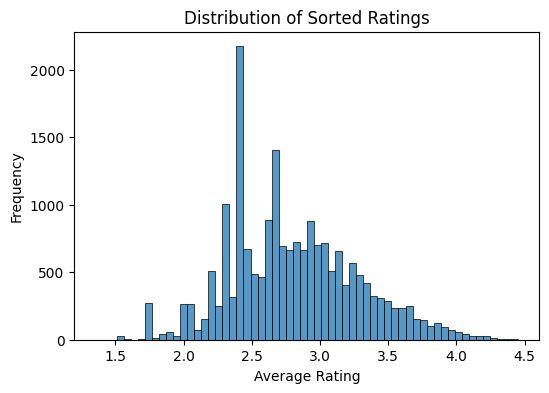

In [39]:
#plt.hist(data_df['ratings_sortable'])
# Histogram with KDE
plt.figure(figsize=(6, 4))
sns.histplot(data_df['ratings_sortable'])
plt.title('Distribution of Sorted Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()


Text(0.5, 1.0, 'Open Library Unread to Read Pipeline')

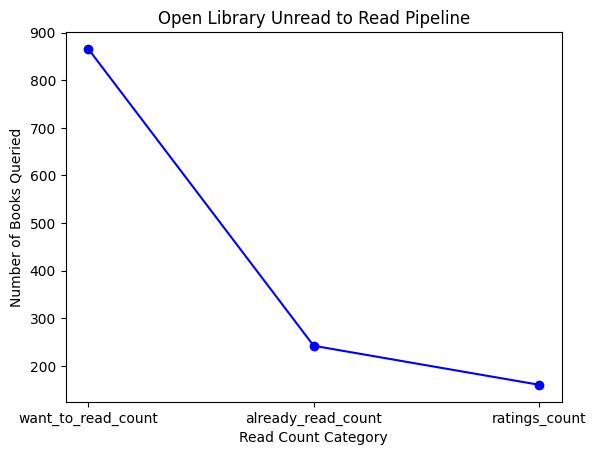

In [36]:
labels = ['want_to_read_count', 'already_read_count', 'ratings_count']
sums = []
for label in labels:
    sums.append(data_df[label].sum())

# Plot engagement pipeline
plt.plot(labels, sums, marker='o', linestyle='-', color='b', label='Read Count')
plt.xlabel('Read Count Category')
plt.ylabel('Number of Books Queried')
plt.title('Open Library Unread to Read Pipeline')

Moving forward, let's first consider each of the following separately: 
1. What book features influence reading count from readers?
2. What book features positively influence ratings from readers?
3. How do these features impact ratings_sortable? A feature that combines and weighs the ratings outcome by the number of ratings?

In [41]:
pop_df = data_df[['author_name', 'first_publish_year','number_of_pages_median','publisher','title','subject','readinglog_count']]

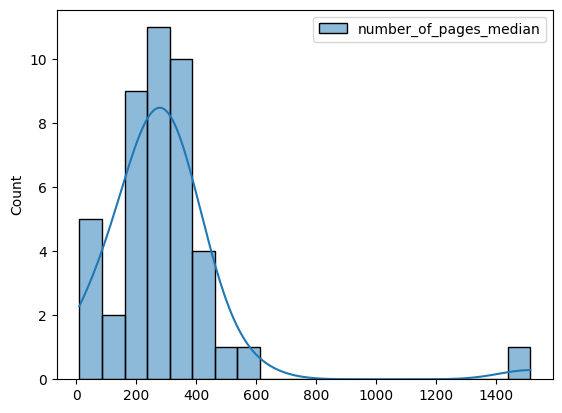

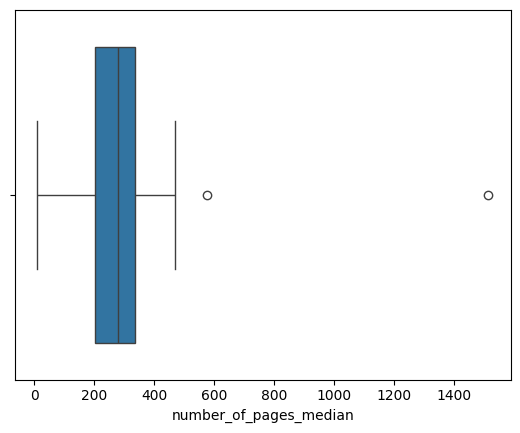

In [42]:
# Target col is readinglog_count = y
# Scale numerical features
import seaborn as sns
fig, axs = plt.subplots(1, 1)
sns.histplot(pop_df[['number_of_pages_median']],kde = True);
fig, axs = plt.subplots(1, 1)
sns.boxplot(data=pop_df, x='number_of_pages_median');
#data_df[['number_of_pages_median']]

In [74]:
# Categorical columns
x = pop_df[['author_name', 'title', 'language', 'publisher', 'subject']]
y = pop_df[['readinglog_count']]

In [46]:
# Summary statistics
print(data_df.describe())

       first_publish_year  number_of_pages_median  ratings_average  \
count        19984.000000            19193.000000     20000.000000   
mean          1984.151371              320.585370         4.023113   
std             49.762119              418.484946         0.755941   
min           1200.000000                1.000000         1.000000   
25%           1979.000000              189.000000         3.666667   
50%           1995.000000              274.000000         4.000000   
75%           2008.000000              400.000000         4.500000   
max           2029.000000            50112.000000         5.000000   

       ratings_sortable  ratings_count  readinglog_count  want_to_read_count  \
count      20000.000000   20000.000000      20000.000000        20000.000000   
mean           2.804902       9.259150        123.010900          100.796550   
std            0.474473      24.765976        622.003499          559.144092   
min            1.355208       1.000000         31

## SUBJECT ANALYSIS

Text Preprocessing
Vectorizing
NLP Modeling: Naive Bayes Classifier
Topic Modeling: the Latent Dirichlet Allocation Algorithm (LDA) (Unsupervised)

In [ ]:
# Extract genres from subject



#Check in subject for each genre and 

In [48]:
data_df['subject']

0        [Fiction, Romance, Contemporary, Life change e...
1        [Habit, Habit breaking, Behavior modification,...
2        [Business, Control (Psychology), Contrôle (Psy...
3        [Self-realization, Conduct of life, Conducta d...
4        [Rich people, Personal Finance, Investments, F...
                               ...                        
19995    [Fiction, World War, 1939-1945 in fiction, Wor...
19996    [Biochemistry, Clinical biochemistry, Examinat...
19997    [History and criticism, Blues (Music), Biograp...
19998    [Architecture, Modern, Modern Architecture, In...
19999    [Cas, Études de, Murder, Meurtre, Case studies...
Name: subject, Length: 20000, dtype: object

In [96]:
#text_subset_df = data_df[['subject', 'readinglog_count']].head(50)
data_df['subject_clean'] = data_df['subject']
data_df

,author_name,first_publish_year,number_of_pages_median,publisher,title,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,bin,title_author,subject_clean
0,[Colleen Hoover],2012.0,384.0,"[Athreya, Simon & Schuster, Epsilon Yayinevi, ...",It Ends With Us,"[Fiction, Romance, Contemporary, Life change e...",4.239496,4.163510,952,38532,35221,2128,1183,1,It Ends With Us by ['Colleen Hoover'],"[Fiction, Romance, Contemporary, Life change e..."
1,[James Clear],2016.0,320.0,"[Random House, Incorporated, editora alta book...",Atomic Habits,"[Habit, Habit breaking, Behavior modification,...",4.054461,3.967740,863,38352,34811,2548,993,1,Atomic Habits by ['James Clear'],"[Habit, Habit breaking, Behavior modification,..."
2,"[Robert Greene, Joost Elffers]",1998.0,452.0,"[Editora Rocco, Viking, Hachette Australia, Ca...",The 48 Laws of Power,"[Business, Control (Psychology), Contrôle (Psy...",4.126276,4.036836,784,32460,29616,2096,748,1,"The 48 Laws of Power by ['Robert Greene', 'Joo...","[Business, Control (Psychology), Contrôle (Psy..."
3,[Mark Manson],2016.0,224.0,"[HarperLuxe, Harpercollins, Mark Manson , Inde...",The Subtle Art of Not Giving a F*ck,"[Self-realization, Conduct of life, Conducta d...",4.116279,4.015137,602,29438,27104,1727,607,1,The Subtle Art of Not Giving a F*ck by ['Mark ...,"[Self-realization, Conduct of life, Conducta d..."
4,"[Robert T. Kiyosaki, Sharon L. Lechter]",1990.0,233.0,"[Running Press, Bespoke Books, Gao Bao/ Tsai F...","Rich Dad, Poor Dad","[Rich people, Personal Finance, Investments, F...",4.083707,3.987700,669,21948,19230,1969,749,1,"Rich Dad, Poor Dad by ['Robert T. Kiyosaki', '...","[Rich people, Personal Finance, Investments, F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,[Arthur Koestler],1943.0,192.0,"[Penguin Classics, Fischer-Taschenbuch-Verlag,...",Arrival and Departure,"[Fiction, World War, 1939-1945 in fiction, Wor...",3.200000,2.380782,5,31,23,3,5,100,Arrival and Departure by ['Arthur Koestler'],"[Fiction, World War, 1939-1945 in fiction, Wor..."
19996,"[Pamela C. Champe, Richard A Harvey, Denise R ...",1987.0,524.0,"[Elsevier Science Ltd, Lippincott/Williams & W...",Biochemistry,"[Biochemistry, Clinical biochemistry, Examinat...",1.000000,1.554519,2,31,22,7,2,100,"Biochemistry by ['Pamela C. Champe', 'Richard ...","[Biochemistry, Clinical biochemistry, Examinat..."
19997,"[Palmer, Robert]",1981.0,310.0,"[Penguin Books, Viking Press, Papermac]",Deep blues,"[History and criticism, Blues (Music), Biograp...",5.000000,2.403664,1,31,28,2,1,100,"Deep blues by ['Palmer, Robert']","[History and criticism, Blues (Music), Biograp..."
19998,[Tom Wolfe],1981.0,128.0,"[Bantam, Picador/Farrar, Straus and Giroux, Ca...",From Bauhaus to our house,"[Architecture, Modern, Modern Architecture, In...",4.000000,2.650674,3,31,26,1,4,100,From Bauhaus to our house by ['Tom Wolfe'],"[Architecture, Modern, Modern Architecture, In..."


In [97]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

def cleaning(sentence):

    # Basic cleaning
    sentence = sentence.strip() ## remove whitespaces
    sentence = sentence.lower() ## lowercase
    #sentence = ''.join(char for char in sentence if not char.isdigit()) ## remove numbers

    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') ## remove punctuation

    tokenized_sentence = word_tokenize(sentence) ## tokenize
    stop_words = set(stopwords.words('english')) ## define stopwords

    tokenized_sentence_cleaned = [ ## remove stopwords
        w for w in tokenized_sentence if not w in stop_words
    ]

    lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos = "v")
        for word in tokenized_sentence_cleaned
    ]

    cleaned_sentence = ' '.join(word for word in lemmatized)

    return cleaned_sentence

In [98]:
def is_list(value):
    return isinstance(value, list)

# Create a boolean mask where the value is a list
mask = data_df['subject_clean'].apply(is_list)

# Create a new DataFrame with only the rows where the value is a list
data_df = data_df[mask]
#text_subset_df



In [99]:
data_df['subject_clean'] = data_df['subject_clean'].apply(lambda lst: [cleaning(s) for s in lst])
#print(text_subset_df)

/var/folders/1g/sdktyfrj7yl34lwprcvwz7t40000gn/T/ipykernel_9100/1157161528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['subject_clean'] = data_df['subject_clean'].apply(lambda lst: [cleaning(s) for s in lst])


In [100]:
# List of widely recognized genres
book_genres = [
    "Literary Fiction",
    "Historical Fiction",
    "Science Fiction",
    "Fantasy",
    "Mystery",
    "Thriller",
    "Romance",
    "Horror",
    "Young Adult",
    "Dystopian",
    "Adventure",
    "Crime",
    "Magical Realism",
    "Graphic Novels",
    "Comics",
    "Biography",
    "Autobiography",
    "Memoir",
    "Self-Help",
    "True Crime",
    "History",
    "Travel",
    "Science",
    "Philosophy",
    "Religion",
    "Spirituality",
    "Business",
    "Economics",
    "Health",
    "Fitness",
    "Politics",
    "Essays",
    "Cookbooks",
    "Art",
    "Photography",
    "Poetry",
    "Drama",
    "Play",
    "Short Stories",
    "Children's",
    "New Adult",
    "Chick Lit",
    "Westerns",
    "Classics"
]

# Function to check if a string matches any genre in the list
def is_genre(string):
    for genre in book_genres:
        if string and string.lower() == genre.lower():
            return string.lower()
    return None

# Function to clean and extract genres from the subject_clean column
def cleaningr(lst):
    matched_genres = []
    for s in lst:
        genre = is_genre(s)
        if genre:
            matched_genres.append(genre)
    return matched_genres

# Apply the function to each row in the subject_clean column
data_df['genre'] = data_df['subject_clean'].apply(lambda lst: cleaningr(lst) if isinstance(lst, list) else [])

print(data_df)

                                             author_name  first_publish_year  \
0                                       [Colleen Hoover]              2012.0   
1                                          [James Clear]              2016.0   
2                         [Robert Greene, Joost Elffers]              1998.0   
3                                          [Mark Manson]              2016.0   
4                [Robert T. Kiyosaki, Sharon L. Lechter]              1990.0   
...                                                  ...                 ...   
19995                                  [Arthur Koestler]              1943.0   
19996  [Pamela C. Champe, Richard A Harvey, Denise R ...              1987.0   
19997                                   [Palmer, Robert]              1981.0   
19998                                        [Tom Wolfe]              1981.0   
19999                                         [Ann Rule]              1992.0   

       number_of_pages_median  \
0     

/var/folders/1g/sdktyfrj7yl34lwprcvwz7t40000gn/T/ipykernel_9100/2729016209.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['genre'] = data_df['subject_clean'].apply(lambda lst: cleaningr(lst) if isinstance(lst, list) else [])


In [101]:
# DataFrame without NaN
sub_genre_df = data_df.dropna(subset=['genre'])

print(sub_genre_df['subject'].apply(type).value_counts())

subject
<class 'list'>    18969
Name: count, dtype: int64


In [104]:
sub_genre_df

,author_name,first_publish_year,number_of_pages_median,publisher,title,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,...,தமிழ்,மொழிபெயர்ப்பு,中国,中國,儒家,勞動力,哲學,孔子,工資,貧窮
0,[Colleen Hoover],2012.0,384.0,"[Athreya, Simon & Schuster, Epsilon Yayinevi, ...",It Ends With Us,"[Fiction, Romance, Contemporary, Life change e...",4.239496,4.163510,952.0,38532.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,[James Clear],2016.0,320.0,"[Random House, Incorporated, editora alta book...",Atomic Habits,"[Habit, Habit breaking, Behavior modification,...",4.054461,3.967740,863.0,38352.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[Robert Greene, Joost Elffers]",1998.0,452.0,"[Editora Rocco, Viking, Hachette Australia, Ca...",The 48 Laws of Power,"[Business, Control (Psychology), Contrôle (Psy...",4.126276,4.036836,784.0,32460.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,[Mark Manson],2016.0,224.0,"[HarperLuxe, Harpercollins, Mark Manson , Inde...",The Subtle Art of Not Giving a F*ck,"[Self-realization, Conduct of life, Conducta d...",4.116279,4.015137,602.0,29438.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[Robert T. Kiyosaki, Sharon L. Lechter]",1990.0,233.0,"[Running Press, Bespoke Books, Gao Bao/ Tsai F...","Rich Dad, Poor Dad","[Rich people, Personal Finance, Investments, F...",4.083707,3.987700,669.0,21948.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# DataFrame
df = data_df[['genre', 'readinglog_count']].dropna(subset='genre')
df = df[df['genre'].apply(lambda x: len(x) > 0)]
df.isna().sum()

genre               0
readinglog_count    0
dtype: int64

In [124]:
# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the subject column
subjects_encoded = mlb.fit_transform(df['genre'])

# Create a DataFrame with the encoded features
subjects_df = pd.DataFrame(subjects_encoded, columns=mlb.classes_)

# Display the encoded DataFrame
print(subjects_df)

      adventure  art  autobiography  biography  business  classics  comics  \
0             0    0              0          0         1         0       0   
1             0    0              0          0         1         0       0   
2             0    0              0          0         0         0       0   
3             0    0              0          0         0         0       0   
4             0    0              0          0         1         0       0   
...         ...  ...            ...        ...       ...       ...     ...   
7095          0    0              0          1         0         0       0   
7096          0    0              0          0         0         0       0   
7097          0    0              0          0         0         0       0   
7098          0    0              0          1         0         0       0   
7099          0    0              0          0         0         0       0   

      cookbooks  crime  drama  ...  romance  science  science f

In [125]:
# Drop the original subject column
df = df.drop('genre', axis=1)

# Concatenate the one-hot encoded features with the original DataFrame
df = pd.concat([df, subjects_df], axis=1)

# Display the updated DataFrame
print(df)


      readinglog_count  adventure  art  autobiography  biography  business  \
1              38352.0        0.0  0.0            0.0        0.0       1.0   
2              32460.0        0.0  0.0            0.0        0.0       0.0   
5              15142.0        0.0  0.0            0.0        0.0       0.0   
6              14730.0        0.0  0.0            0.0        0.0       0.0   
8              10675.0        0.0  0.0            0.0        0.0       0.0   
...                ...        ...  ...            ...        ...       ...   
7089               NaN        0.0  0.0            0.0        0.0       0.0   
7091               NaN        0.0  0.0            0.0        0.0       0.0   
7094               NaN        0.0  0.0            0.0        0.0       0.0   
7095               NaN        0.0  0.0            0.0        1.0       0.0   
7098               NaN        0.0  0.0            0.0        1.0       0.0   

      classics  comics  cookbooks  crime  ...  romance  science

In [126]:
#Step 3: Split the data into training and test sets
X = df.drop('readinglog_count', axis=1)
X

,adventure,art,autobiography,biography,business,classics,comics,cookbooks,crime,drama,...,romance,science,science fiction,short stories,spirituality,thriller,travel,true crime,westerns,young adult
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7095,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
X.describe()

,adventure,art,autobiography,biography,business,classics,comics,cookbooks,crime,drama,...,romance,science,science fiction,short stories,spirituality,thriller,travel,true crime,westerns,young adult
count,7100.000000,7100.000000,7100.000000,7100.000000,7100.000000,7100.000000,7100.000000,7100.000000,7100.000000,7100.000000,...,7100.000000,7100.00000,7100.000000,7100.000000,7100.000000,7100.000000,7100.000000,7100.000000,7100.000000,7100.000000
mean,0.018028,0.015211,0.005493,0.135352,0.025352,0.021268,0.001408,0.000845,0.012535,0.040423,...,0.126901,0.03338,0.110000,0.036761,0.007324,0.026761,0.021831,0.003944,0.000141,0.008451
std,0.133063,0.122401,0.073916,0.342123,0.157203,0.144285,0.037506,0.029060,0.111265,0.196962,...,0.332886,0.17964,0.312912,0.188187,0.085272,0.161394,0.146142,0.062679,0.011868,0.091545
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [127]:
y = df['readinglog_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared: {r2_score(y_test, y_pred)}')

# Feature importance
feature_importance = pd.Series(model.coef_, index=X.columns)
print(feature_importance)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values